<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-логистической-регрессии." data-toc-modified-id="Модель-логистической-регрессии.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель логистической регрессии.</a></span></li><li><span><a href="#Модель-решающего-дерева." data-toc-modified-id="Модель-решающего-дерева.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель решающего дерева.</a></span></li><li><span><a href="#Модель-случайного-леса." data-toc-modified-id="Модель-случайного-леса.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель случайного леса.</a></span></li><li><span><a href="#Catboost." data-toc-modified-id="Catboost.-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Catboost.</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span><ul class="toc-item"><li><span><a href="#Тестирование-лучшей-модели." data-toc-modified-id="Тестирование-лучшей-модели.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Тестирование лучшей модели.</a></span></li><li><span><a href="#Проверка-на-адекватность." data-toc-modified-id="Проверка-на-адекватность.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Проверка на адекватность.</a></span></li></ul></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

**Задача:**

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# !pip install -U spacy

In [2]:
# Загрузка необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import notebook
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords as nltk_stopwords

import spacy

import re

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from catboost import Pool, CatBoostClassifier, cv

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Подключим tqdm.

tqdm.pandas(desc='progress')

In [4]:
# Зададим значения для генерации случайных величин

RANDOM_STATE = 12345 

In [5]:
# Загрузим данные из файло
try:
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [6]:
# Выведем дата-фрейм на экран.

df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
# Выведем общую информацию о дата-фрейме.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


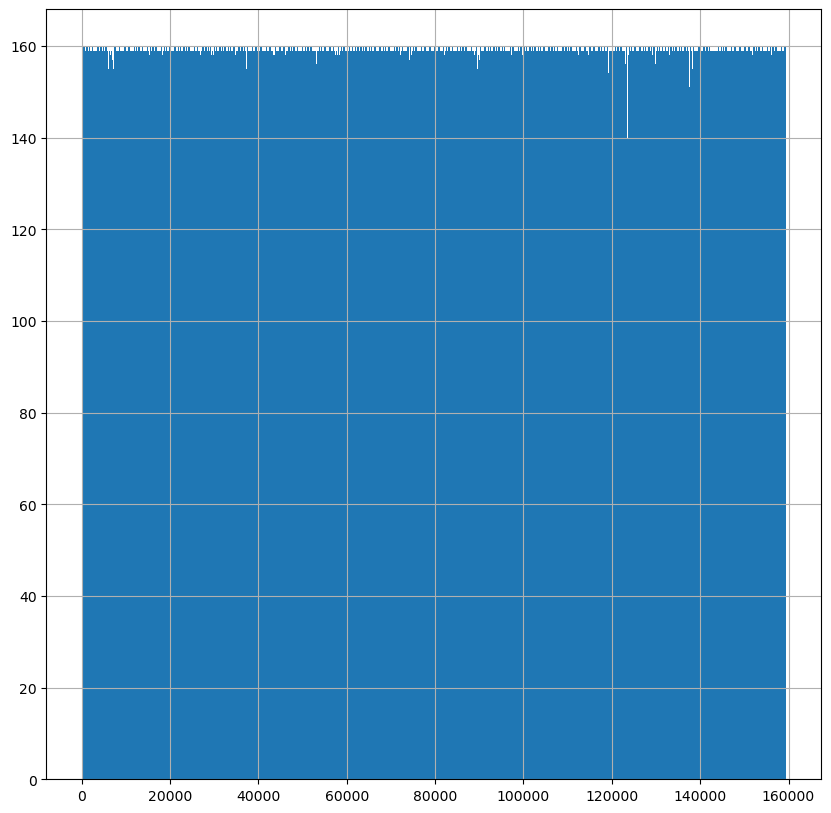

In [8]:
# Посмотрим на распределение значений столбца 'Unnamed: 0'.

df['Unnamed: 0'].hist(bins=1000, figsize=(10,10));

Столбец 'Unnamed: 0', в принципе, соответствуеи индексу (порядковому номеру) поста, однако некоторые посты не попали  во фрейм. Причина нам неизвестна. Сохраним данные этого столбца, будем его использовать к качестве индекса.

In [9]:
# Используем столбец 'Unnamed: 0' в качестве индекса.

df = df.set_index('Unnamed: 0', drop=True)

In [10]:
# Проверим на наличие явных дубликатов.

df.duplicated().sum()

0

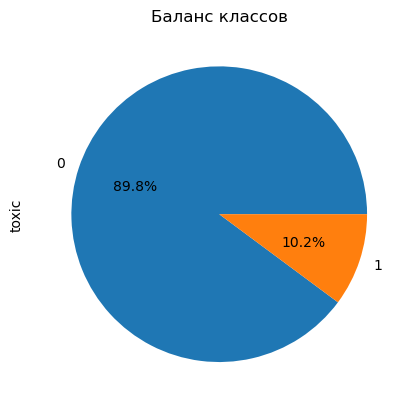

In [11]:
# Проверим баланс классов.

df['toxic'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Баланс классов')
plt.show()

In [12]:
# Функция очистки текста

def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z\']', ' ', text) 
    final_text = ' '.join(clear_text.split())
    return final_text


In [13]:
%%time
# Очистим текст и запишем в новый столбец.

df['lemm_text'] = df['text'].progress_apply(lambda x: clear_text(x))

progress: 100%|█████████████████████████████████████████████████████████████| 159292/159292 [00:05<00:00, 27004.25it/s]

Wall time: 5.92 s


In [14]:
# Выведем новый столбец с очищенным текстом. 

df['lemm_text'].head()

Unnamed: 0
0    Explanation Why the edits made under my userna...
1    D'aww He matches this background colour I'm se...
2    Hey man I'm really not trying to edit war It's...
3    More I can't make any real suggestions on impr...
4    You sir are my hero Any chance you remember wh...
Name: lemm_text, dtype: object

In [15]:
# Инициализируем модель spacy для англ. языка, оставив только нужные компоненты.

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [16]:
# Лемматизируем текст в pipe-line.

lemm_texts = []
total = df.shape[0]
nlp_pipe = nlp.pipe(df['lemm_text'].values, disable = ['ner', 'parser'])

for doc in tqdm(nlp_pipe, total=total):
    lemm_text = " ".join([token.lemma_ for token in doc])    
    lemm_texts.append(lemm_text) 

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [12:02<00:00, 220.49it/s]


In [17]:
# Запишем лемматизированный текст в столбец.

df['lemm_text'] = lemm_texts

In [18]:
# Выведем обработанный текст.

df['lemm_text'].head()

Unnamed: 0
0    Explanation why the edit make under my usernam...
1    D'aww he match this background colour I be see...
2    hey man I be really not try to edit war it be ...
3    More I can not make any real suggestion on imp...
4    you sir be my hero any chance you remember wha...
Name: lemm_text, dtype: object

In [19]:
# Разделим данные на признаки и целевой признак.

features = df['lemm_text']
target = df['toxic']

In [20]:
# Разделим данные на обучающую и тестовые выборки.

features_train, features_test, target_train, target_test =\
train_test_split(features, target, test_size=0.1, random_state=RANDOM_STATE, stratify=target)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(143362,)
(15930,)
(143362,)
(15930,)


In [21]:
# Проверии соотношение классов в обучающей выборке.

len(target_train[target_train == 1]) / len(target_train[target_train == 0])

0.1131022167009589

In [22]:
# Загрузим список стоп-слов.

nltk.download('stopwords') 
stop_words = nltk_stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Выводы по разделу:**
- Пропусков нет;
- Явных дубликатов нет;
- Имеется выраженный дисбаланс классов;
- Сохраним данные столбца 'Unnamed 0:', будем его использовать к качестве индекса, сам столбец удалим;
- Очистили текстовые данные от лишних знаков, лемматихировали при помощи SpiCy;
- Разбили данные на обучающую и тестовую выборки.

## Обучение

### Модель логистической регрессии.

In [23]:
# Создадим pipeline для векторизации признаков и обучения модели логистической регрессии.

pipe_reg = Pipeline(steps=[('vect', TfidfVectorizer(stop_words=stop_words)), 
                           ('reg', LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE,\
                                                     ))],\
                    verbose=False)

In [24]:
# Параметры для GridseachCV

grid_space_lg={ 'vect__sublinear_tf': (True, False),
                'reg__C': (0.1, 1, 5, 10)
                }

In [25]:
# Создадим подборщик параметров для модели дерева решений

lg_grid = GridSearchCV(pipe_reg,param_grid=grid_space_lg,n_jobs=-1,scoring= \
                         'f1', cv=2)

In [26]:
%%time
# Обучим модель, подберем параметры на кросс-валидации.

lg_model = lg_grid.fit(features_train, target_train)

# Выведем лучший результат метрики и лучшие подобранные гиперпараметры.

f1_lg = lg_model.best_score_
params_lg = lg_model.best_params_
print(f1_lg)
print(params_lg)

0.7687736711505812
{'reg__C': 10, 'vect__sublinear_tf': True}
Wall time: 1min 39s


Время обучения и подбора параметров около 2 мин.

### Модель решающего дерева.

In [27]:
# Создадим pipeline для векторизации признаков и обучения модели решающего дерева.

pipe_tree = Pipeline(steps=[('vect', TfidfVectorizer(stop_words=stop_words)), 
                           ('tree', DecisionTreeClassifier(class_weight='balanced',\
                                                           random_state=RANDOM_STATE))], verbose=False)

In [28]:
# Параметры для побора RandomSeach.

param_tree = {'vect__sublinear_tf': [True, False],
              'tree__max_depth': [3, 15, 30],
              'tree__max_features':[1, 15, 30],
              'tree__min_samples_leaf':[1, 3],
              'tree__min_samples_split':[2, 3]
        
            }

In [29]:
#  Создадим подборщик параметров для модели.

tree_random = RandomizedSearchCV(pipe_tree,param_distributions=param_tree,\
                                        n_jobs=-1, n_iter=6,cv=3, scoring='f1')

In [30]:
%%time
# Обучим модель, подберем параметры на кросс-валидации.

tree_model = tree_random.fit(features_train, target_train)

# Выведем лучший результат метрики и лучшие подобранные гиперпараметры.

f1_tree = tree_model.best_score_
params_tree = tree_model.best_params_
print(f1_tree)
print(params_tree)


0.19190026828430776
{'vect__sublinear_tf': False, 'tree__min_samples_split': 3, 'tree__min_samples_leaf': 1, 'tree__max_features': 15, 'tree__max_depth': 15}
Wall time: 1min 20s


Время обучения и подбора параметров порядка 1.5 мин.

### Модель случайного леса.

In [31]:
# Создадим pipeline для векторизации признаков и обучения модели случайного леса.

pipe_forest = Pipeline(steps=[('vect', TfidfVectorizer(stop_words=stop_words)), 
                           ('forest', RandomForestClassifier(class_weight='balanced',\
                                                           random_state=RANDOM_STATE))], verbose=False)

In [32]:
# Параметры для побора RandomSeach.

param_forest = {'vect__sublinear_tf': [True, False],
                'forest__n_estimators': [15, 30],
                'forest__max_depth': [40, 60]
               }

In [33]:
#  Создадим подборщик параметров для модели.

forest_random = RandomizedSearchCV(pipe_forest,param_distributions=param_forest,\
                                        n_jobs=-1, n_iter=4,cv=2, scoring='f1')

In [34]:
%%time
# Обучим модель, подберем парметры на кросс-валидации.

forest_model = forest_random.fit(features_train, target_train)

# Выведем лучший результат метрики и лучшие подобранные гиперпараметры.

f1_forest = forest_model.best_score_
params_forest = forest_model.best_params_
print(f1_forest)
print(params_forest)

0.49821169818571986
{'vect__sublinear_tf': False, 'forest__n_estimators': 30, 'forest__max_depth': 60}
Wall time: 5min 12s


Время обучения чуть около 2-х минут.

### Catboost.

In [35]:
# Pipeline для векторизации, обучения модели и подбора параметров CatBoostClassifier.

pipe_cat = Pipeline(steps=[
          ('vect', TfidfVectorizer(stop_words=stop_words)),
          ('cat', CatBoostClassifier(random_state=RANDOM_STATE, auto_class_weights='Balanced', iterations=100,\
                                     verbose=500))
          ], verbose=False)

In [36]:
# Параметры для RandomseachCV для модели CatBoostClassifier.

param_cat = {'vect__sublinear_tf': [True, False],
            'cat__learning_rate': [0.1, 0.5],
            }

In [37]:
# Создадим подборщик параметров для модели CatBoostClassifier.

cat = RandomizedSearchCV(pipe_cat,param_distributions=param_cat,\
                                        n_jobs=-1, n_iter=4,cv=2, scoring='f1')

In [38]:
%%time

# Обучение модели CatBoostClassifier, подбор параметров и подсчет метрики.

cat_model = cat.fit(features_train, target_train)

# Выведем лучший результат метрики и лучшие подобранные гиперпараметры.

f1_cat = cat_model.best_score_
params_cat = cat_model.best_params_
print(round(f1_cat, 3))
print(params_cat)

0:	learn: 0.5648104	total: 2.44s	remaining: 4m 1s
99:	learn: 0.2289802	total: 3m 5s	remaining: 0us
0.735
{'vect__sublinear_tf': True, 'cat__learning_rate': 0.5}
Wall time: 16min 35s


Время обучения и подбора параметров около 17 мин.

## Выводы

In [39]:
# Cоставим списки по результатам обучения и кросс-валидации моделей.

models = ['Логистическая регрессия', 'Решающее дерево', 'Случайный лес', 'CatBoostRegressor']
res = [[round(f1_lg, 3 )],
        [round(f1_tree,3 )],
        [round(f1_forest, 3)],
        [round(f1_cat, 3)]]

In [40]:
# Создадим дата-фрейм с результатами кросс-валидации моделей.

result_data = pd.DataFrame(data=res, index=models, columns=['Качество предсказания (F1-мера)'])
result_data

,Качество предсказания (F1-мера)
Логистическая регрессия,0.769
Решающее дерево,0.192
Случайный лес,0.498
CatBoostRegressor,0.735


***Выводы по разделу:***

По результатам обучения 4 моделей ('Логистическая регрессия', 'Решающее дерево', 'Случайный лес', 'CatBoostRegressor') лучшее значение метрики 'F1-мера' показала модель логистической регрессии в конвейере с TfidfVectorizer со следующими гиперпараметрами:
- TfidfVectorizer(sublinear_tf=True);
- LogisticRegression(class_weight='balanced', С=10)

### Тестирование лучшей модели.

In [41]:
%%time
# Делаем предсказания на тествой.

reg_predictions = lg_model.best_estimator_.predict(features_test)
# Проверяем и выводим результат метрики на тестовой выборке.

f1_reg_test = f1_score(target_test, reg_predictions)
print('Значение F1-меры модели логистической регресси на тестовой выборке:', round(f1_reg_test, 3))

Значение F1-меры модели логистической регресси на тестовой выборке: 0.785
Wall time: 3.54 s


###  Проверка на адекватность.

In [42]:
# Создадим модель DummyClassifier.

dummy_class = DummyClassifier(strategy='constant', constant=1)
dummy_class.fit(features_train, target_train)
dummy_pred = dummy_class.predict(features_test)
f1_dummy_test = f1_score(target_test, dummy_pred)
print('Значение F1-меры при заполнении константой:', round(f1_dummy_test, 2))

Значение F1-меры при заполнении константой: 0.18


***Итоговые выводы:***
- Провели предобработку данных и лемматизировали текст;
- Векторизовали текст и обучили разные модели;
- Лучшими на кросс-валидации и подборе параметров себя показали: модели Логистической Регрессия;
- Провели проверку лучшей модели на тестовой выборке;
- Лучшая модель Логистической регрессии показала на тестовой выборке значение метрики F1 равное 0,785;
- Модель адекватна, значение метрики лучшей модели много лучше заполнения константой.